In [67]:
from main import Unsupervised_FF, train, plot_loss
import torch, torchvision
from torch.utils.data import DataLoader
from torch.nn.functional import cosine_similarity
from utils import prepare_data

In [68]:
prepare_data()

# Load the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
# pos_dataset = Subset(pos_dataset, list(range(1000)))
# Create the data loader
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the transformed images
neg_dataset = torch.stack(torch.load('transformed_dataset.pt'))
# Create the data loader
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the test images
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
# Create the data loader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unsupervised_ff = Unsupervised_FF(device=device, n_epochs=10)

loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

Training Last Layer: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


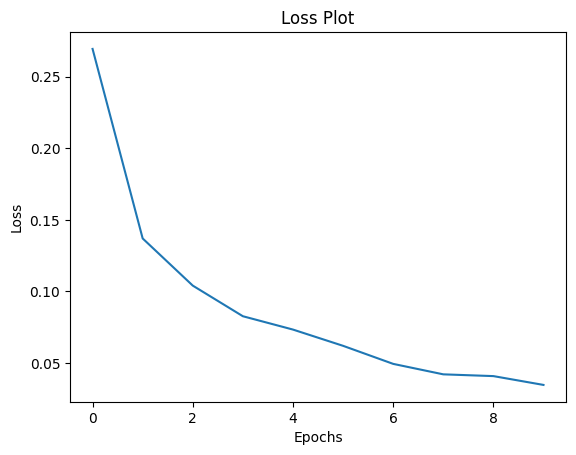

In [70]:
plot_loss(loss)

In [71]:
unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")

Train dataset scores:  accuracy_score: 0.988


Test dataset scores:  accuracy_score: 0.9637


In [72]:
from tqdm import tqdm
inner_tqdm = tqdm(test_dataloader, desc=f"Evaluating model", leave=False, position=1)
all_encodings = []
for image, labels in inner_tqdm:
    image = image[0].to(unsupervised_ff.device)
    all_encodings.append(unsupervised_ff.encoding(image).detach().cpu())

all_encodings = torch.stack(all_encodings)


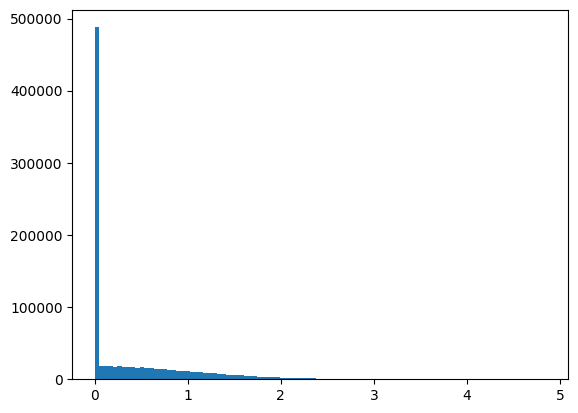

tensor(2092.0190)
torch.Size([1, 1, 6000])


In [73]:
from matplotlib import pyplot as plt
from traitlets import All   
plt.hist(all_encodings.flatten().numpy(), bins=100)
plt.show()
print(sum(all_encodings[0][all_encodings[0] > 0.5]))
print(all_encodings[0].shape)

In [74]:
def get_weights(model):
    weights = {}
    for idx, layer in enumerate(model.ff_layers):
        weights[f"layer_{idx}"] = layer.weight.data
    weights["last_layer"] = model.last_layer.weight.data
    return weights

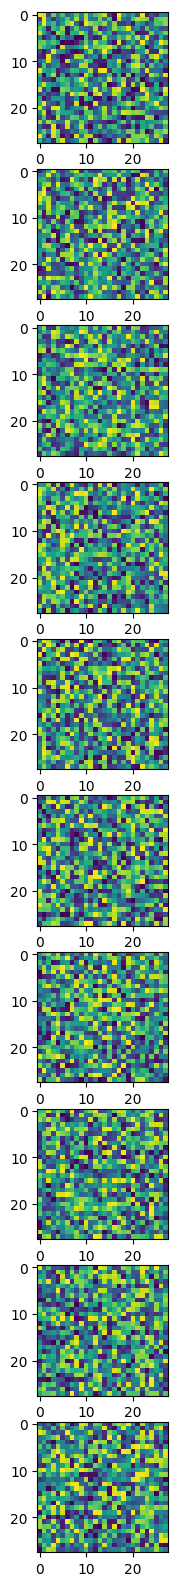

In [75]:
layer_0 = get_weights(unsupervised_ff)["layer_0"]
plt.figure(figsize=(10, 20))
num_neurons = 10
for neuron in range(num_neurons):
    plt.subplot(num_neurons, 1, neuron+1)
    plt.imshow(layer_0[neuron].reshape(28, 28).cpu().numpy().T)

In [76]:
def get_sparse_representation(model, image):
    encodings = model.encoding(image)
    return encodings.reshape(-1).detach()

In [77]:
import random
import numpy as np
from scipy.spatial.distance import hamming
sparse_representations = [[] for _ in range(10)]
for x_batch, y_batch in test_dataloader:
    for x, y in zip(x_batch, y_batch):
        sparse_representations[y.item()].append(get_sparse_representation(unsupervised_ff, x))

In [78]:
similarities_c = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            similarity_c = cosine_similarity(sparse_representations[i][j].unsqueeze(0), sparse_representations[i][k].unsqueeze(0))
            similarities_c[i].append(similarity_c.item())

In [84]:
similarities_h = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            binary_i_j = np.where(sparse_representations[i][j].cpu().numpy() > 0.1, 1, 0)
            binary_random_k = np.where(sparse_representations[i][k].cpu().numpy() > 0.1, 1, 0)
            similarity_h = hamming(binary_i_j, binary_random_k)
            similarities_h[i].append(similarity_h)

In [80]:
dissimilarities_c = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            while True:
                random_class = random.randint(0,9)
                if random_class != i:
                    break
            dissimilarity_c = cosine_similarity(sparse_representations[i][j].unsqueeze(0), sparse_representations[random_class][k].unsqueeze(0))
            dissimilarities_c[i].append(dissimilarity_c.item())

In [85]:
dissimilarities_h = [[] for _ in range(10)]
for i in range(10):
    for j in range(50):
        for k in range(j+1, 50):
            while True:
                random_class = random.randint(0,9)
                if random_class != i:
                    break
            binary_i_j = np.where(sparse_representations[i][j].cpu().numpy() > 0.1, 1, 0)
            binary_random_k = np.where(sparse_representations[random_class][k].cpu().numpy() > 0.1, 1, 0)
            dissimilarity_h = hamming(binary_i_j, binary_random_k)
            dissimilarities_h[i].append(dissimilarity_h)

In [86]:
for i in range(10):
    average_similarity_c = np.mean(similarities_c[i])
    std_dev_similarity_c = np.std(similarities_c[i])
    print(f"Average similarity for digit {i}: {average_similarity_c}, Standard Deviation: {std_dev_similarity_c}")

    average_similarity_h = np.mean(similarities_h[i])
    std_dev_similarity_h = np.std(similarities_h[i])
    print(f"Average similarity for digit {i}: {average_similarity_h}, Standard Deviation: {std_dev_similarity_h}")

    average_dissimilarity_c = np.mean(dissimilarities_c[i])
    std_dev_dissimilarity_c = np.std(dissimilarities_c[i])
    print(f"Average dissimilarity for digit {i}: {average_dissimilarity_c}, Standard Deviation: {std_dev_dissimilarity_c}")

    average_dissimilarity_h = np.mean(dissimilarities_h[i])
    std_dev_dissimilarity_h = np.std(dissimilarities_h[i])
    print(f"Average dissimilarity for digit {i}: {average_dissimilarity_h}, Standard Deviation: {std_dev_dissimilarity_h}")
    

Average similarity for digit 0: 0.7686388130577243, Standard Deviation: 0.06553500508209609
Average similarity for digit 0: 0.23894585034013605, Standard Deviation: 0.0400968280112925
Average dissimilarity for digit 0: 0.68371384489293, Standard Deviation: 0.04466806044445073
Average dissimilarity for digit 0: 0.28664829931972785, Standard Deviation: 0.024347416538906638
Average similarity for digit 1: 0.7660756768499102, Standard Deviation: 0.08226834700602996
Average similarity for digit 1: 0.23864095238095234, Standard Deviation: 0.052105862031540044
Average dissimilarity for digit 1: 0.6824958317620413, Standard Deviation: 0.038539587241733016
Average dissimilarity for digit 1: 0.29019863945578234, Standard Deviation: 0.021206711767722493
Average similarity for digit 2: 0.7378064035396187, Standard Deviation: 0.05037716746967404
Average similarity for digit 2: 0.2577877551020408, Standard Deviation: 0.029131783372176624
Average dissimilarity for digit 2: 0.6972062858270139, Standar

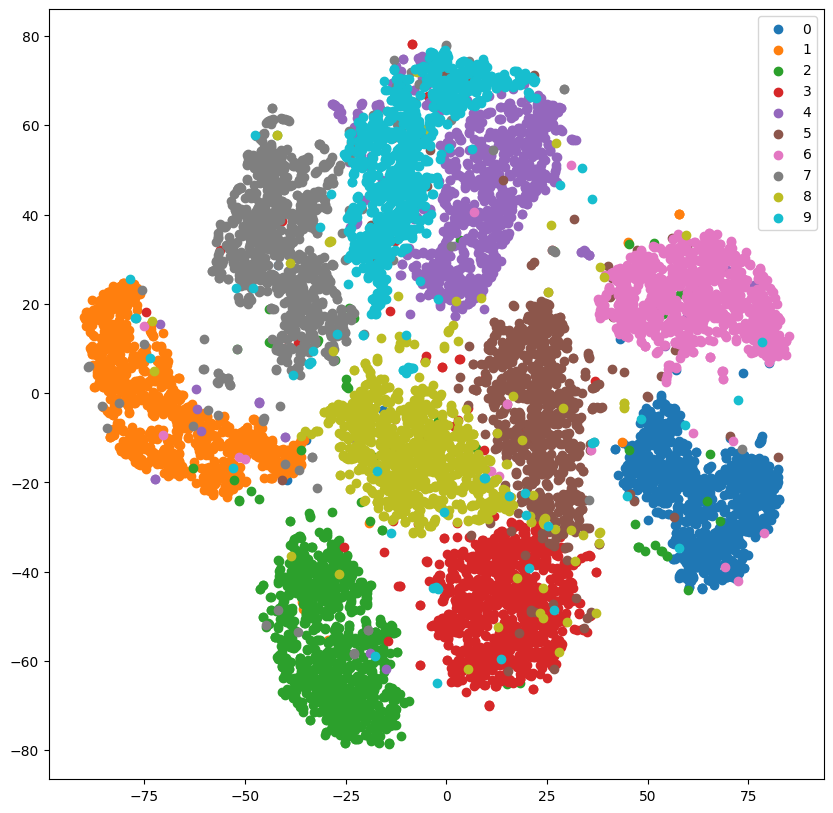

In [83]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

flattened_representations = []
labels = []
for i in range(10):
    flattened_representations.extend([tensor.cpu() for tensor in sparse_representations[i]])
    labels.extend([i] * len(sparse_representations[i]))

flattened_representations = np.array(flattened_representations)

tsne = TSNE(n_components=2, random_state=0)
representations_2d = tsne.fit_transform(flattened_representations)

plt.figure(figsize=(10, 10))
for i in range(10):
    mask = np.array(labels) == i
    plt.scatter(representations_2d[mask, 0], representations_2d[mask, 1], label=str(i))
plt.legend()
plt.show()